# Portfolio Optimization

## 준비 단계

### 필요 라이브러리 로드 및 환경변수 설정

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import math

plt.style.use('seaborn-whitegrid')
plt.rc('font', family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)

### 원시 가격 데이터 로드 및 전처리

In [2]:
# ./data 폴더의 BloombergMain.py(융기원 코드)를 통해 생성한 csv파일을 불러온다.
data = pd.read_csv('../data/data.csv', index_col=0, parse_dates=True)

In [3]:
data.head()

,DBE US Equity,IAU US Equity,SLV US Equity,AIA US Equity,VPL US Equity,VGK US Equity,VWO US Equity,VXUS US Equity,RWO US Equity,VOO US Equity,VO US Equity,VB US Equity,SCHH US Equity,EMLC US Equity,AGG US Equity
Date,,,,,,,,,,,,,,,
2003-09-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.4037
2003-09-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.2468
2003-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.5438
2003-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.5158
2003-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.4261


In [4]:
tickers = data.columns.values

In [5]:
def preprocessing(data):
    # 일자별 종가인 dataframe을 받아서 nan값 제거, linear interpolation을 한후 로그일간수익율로 변환하여 반환한다.
    df = data.dropna(thresh=4)
    df = df.interpolate(method='linear', limit_direction='forward')  # 연휴에 따른 급격한 변화를 smoothing해주기 위해 interpolation
    df = df.dropna()
    dr = np.log(df).diff(1).dropna()
    return dr

In [6]:
df = preprocessing(data)
df.to_csv('../data/data_preprocessed.csv')

### 로그수익율 파일을 로드해서 시작하는 경우

In [7]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
import tensorflow_probability as tfp

# tensorflow의 래핑 라이브러리인 keras에서 본 튜토리얼에 사용할 기능들
from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import Input
# from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam

plt.style.use('seaborn-whitegrid')
plt.rc('font', family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)

In [8]:
# 로그수익율로 전처리 완료된 파일을 불러온다.
dr = pd.read_csv('../data/data_preprocessed.csv', index_col=0, parse_dates=True)
# dr = pd.read_csv('https://github.com/suhan-jung/portfolio_optimization/blob/master/data/data_preprocessed.csv', index_col=0, parse_dates=True)
print(dr.index)

DatetimeIndex(['2011-01-31', '2011-02-01', '2011-02-02', '2011-02-03',
               '2011-02-04', '2011-02-07', '2011-02-08', '2011-02-09',
               '2011-02-10', '2011-02-11',
               ...
               '2022-03-14', '2022-03-15', '2022-03-16', '2022-03-17',
               '2022-03-18', '2022-03-21', '2022-03-22', '2022-03-23',
               '2022-03-24', '2022-03-25'],
              dtype='datetime64[ns]', name='Date', length=2808, freq=None)


### Train / Test data 분리 - 8 : 2

In [9]:
# train data : test data = 80 : 20
train_index = int(dr.shape[0]*0.8)
print(train_index)
# 80:20 으로 train / test 분할 (numpy array로 변환)
train_data = dr[:train_index].values
train_date = dr[:train_index].index.values.astype('datetime64[D]')
print("train data index")
print(dr[:train_index].index)
test_data = dr[train_index:].values
test_date = dr[train_index:].index.values.astype('datetime64[D]')
print("test data index")
print(dr[train_index:].index)


2246
train data index
DatetimeIndex(['2011-01-31', '2011-02-01', '2011-02-02', '2011-02-03',
               '2011-02-04', '2011-02-07', '2011-02-08', '2011-02-09',
               '2011-02-10', '2011-02-11',
               ...
               '2019-12-18', '2019-12-19', '2019-12-20', '2019-12-23',
               '2019-12-24', '2019-12-26', '2019-12-27', '2019-12-30',
               '2019-12-31', '2020-01-02'],
              dtype='datetime64[ns]', name='Date', length=2246, freq=None)
test data index
DatetimeIndex(['2020-01-03', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10', '2020-01-13', '2020-01-14',
               '2020-01-15', '2020-01-16',
               ...
               '2022-03-14', '2022-03-15', '2022-03-16', '2022-03-17',
               '2022-03-18', '2022-03-21', '2022-03-22', '2022-03-23',
               '2022-03-24', '2022-03-25'],
              dtype='datetime64[ns]', name='Date', length=562, freq=None)


In [10]:
train_date

array(['2011-01-31', '2011-02-01', '2011-02-02', ..., '2019-12-30',
       '2019-12-31', '2020-01-02'], dtype='datetime64[D]')

### Data 준비 - sliding window

In [11]:
def make_data_window(data, window_size_past, window_size_future):
    # sequential data와 과거데이터 수, 미래 데이터 수 를 받아서 과거데이터 ndarray, 미래데이터 ndarray를 반환한다.
    inputs_past = []
    inputs_future = []
    for i in range(len(data)-window_size_past-window_size_future):
        inputs_past.append(data[i:i+window_size_past].copy())
        inputs_future.append(data[i+window_size_past:i+window_size_past+window_size_future].copy())
        
    np_inputs_past = np.array(inputs_past)
    np_inputs_future = np.array(inputs_future)
    return np_inputs_past, np_inputs_future

In [12]:
# 자산배분비율 산출 기준 : 과거 60일 데이터로 산출, 미래 20일의 최적수익율로 최적화
window_size_past = 60
window_size_future = 20

xc_train, xf_train = make_data_window(train_data, window_size_past, window_size_future)
xc_test, xf_test = make_data_window(test_data, window_size_past, window_size_future)


In [13]:
print("xc_train.shape:",xc_train.shape)
print("xf_train.shape:",xf_train.shape)
print("xc_test.shape:",xc_test.shape)
print("xf_test.shape:",xf_test.shape)

xc_train.shape: (2166, 60, 15)
xf_train.shape: (2166, 20, 15)
xc_test.shape: (482, 60, 15)
xf_test.shape: (482, 20, 15)


## MPN(Markowitz Portfolio Network)

### 주요 상수 설정

In [14]:
# 월간 수익율 정도의 스케일로 변환한다.(아마퀀트님 코드)
xc_train = xc_train.astype('float32') * 20.0
xf_train = xf_train.astype('float32') * 20.0
xc_test = xc_test.astype('float32') * 20.0
xf_test = xf_test.astype('float32') * 20.0

N_TIME = xc_train.shape[1]
N_FUTURE = xf_train.shape[1]
N_STOCKS = xf_train.shape[2]

# 입력 순서에 따른 상관성을 제거하기 위해 sklearn.utils의 함수를 이용해서 shuffle을 수행한다.
xc_train, xf_train = shuffle(xc_train, xf_train)

# over confidence를 제어할 조절 변수 정의
# GAMMA_CONST = 0.1
GAMMA_CONST = 0.005
# REG_CONST = 0.1
REG_CONST = 0.005
SAVE_MODEL = '../model/mpn.h5'

In [15]:
N_TIME, N_FUTURE

(60, 20)

### 목적함수 정의

In [16]:
def markowitz_objective(y_true, y_pred):
    W = y_pred
    xf_rtn = y_true
    W = tf.expand_dims(W, axis=1)
    R = tf.expand_dims(tf.reduce_mean(xf_rtn, axis=1), axis=2)
    C = tfp.stats.covariance(xf_rtn, sample_axis=1)
    
    rtn = tf.matmul(W, R)
    vol = tf.matmul(W, tf.matmul(C, tf.transpose(W, perm=[0,2,1]))) * GAMMA_CONST
    reg = tf.reduce_sum(tf.square(W), axis=-1) * REG_CONST
    objective = rtn - vol - reg
    
    return -tf.reduce_mean(objective, axis=0)

LSTM 모델 생성

In [17]:
# LSTM으로 Markowitz 모델을 생성한다.
xc_input = Input(batch_shape=(None, N_TIME, N_STOCKS))
h_lstm = LSTM(64, dropout=0.5)(xc_input)
y_output = Dense(N_STOCKS, activation='tanh')(h_lstm)

# 특정 종목을 과도하게 매수하는 것을 방지하기 위해 위에서 tanh를 사용했다.(over confidence 방지용)
# REG_CONST를 적용했기때문에 이미 고려된 사항이지만, 안전을 위해 추가했다.

# 마코비츠의 최적 weights
y_output = Activation('softmax')(y_output)

model = Model(inputs=xc_input, outputs=y_output)
model.compile(loss=markowitz_objective, optimizer=Adam(learning_rate=1e-5))

### 모델 학습

In [18]:
# MPN을 학습하고 결과를 저장한다.
hist = model.fit(xc_train, xf_train, epochs=150, batch_size=32, validation_data=(xc_test, xf_test))
model.save(SAVE_MODEL)

Epoch 1/150
68/68 [==============================] - 3s 19ms/step - loss: -0.0023 - val_loss: -0.0153
Epoch 2/150
68/68 [==============================] - 1s 12ms/step - loss: -0.0023 - val_loss: -0.0153
Epoch 3/150
68/68 [==============================] - 1s 12ms/step - loss: -0.0023 - val_loss: -0.0153
Epoch 4/150
68/68 [==============================] - 1s 12ms/step - loss: -0.0023 - val_loss: -0.0153
Epoch 5/150
68/68 [==============================] - 1s 12ms/step - loss: -0.0023 - val_loss: -0.0153
Epoch 6/150
68/68 [==============================] - 1s 12ms/step - loss: -0.0023 - val_loss: -0.0153
Epoch 7/150
68/68 [==============================] - 1s 12ms/step - loss: -0.0023 - val_loss: -0.0153
Epoch 8/150
68/68 [==============================] - 1s 13ms/step - loss: -0.0023 - val_loss: -0.0153
Epoch 9/150
68/68 [==============================] - 1s 12ms/step - loss: -0.0023 - val_loss: -0.0153
Epoch 10/150
68/68 [==============================] - 1s 12ms/step - loss: -0.0023

### 학습결과 확인(loss)

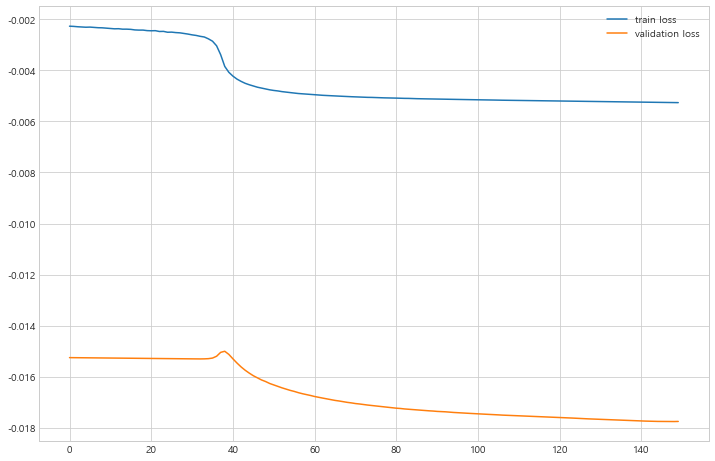

In [19]:
# loss trajectory를 확인한다.
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

### 최적 투자비율 추정

In [20]:
xc_test[0].reshape(1, N_TIME, N_STOCKS).shape

(1, 60, 15)

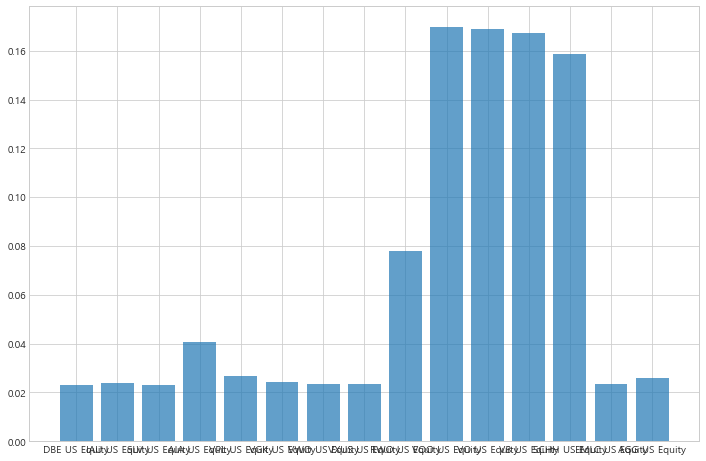

In [21]:
def check_w(n=0):
    plt.figure(figsize=(12,8))
    y_pred = model.predict(xc_test[n].reshape(1, N_TIME, N_STOCKS))[0]
    # plt.bar(np.arange(N_STOCKS), y_pred, alpha=0.7)
    plt.bar(tickers, y_pred, alpha=0.7)
    plt.show()

check_w(0)

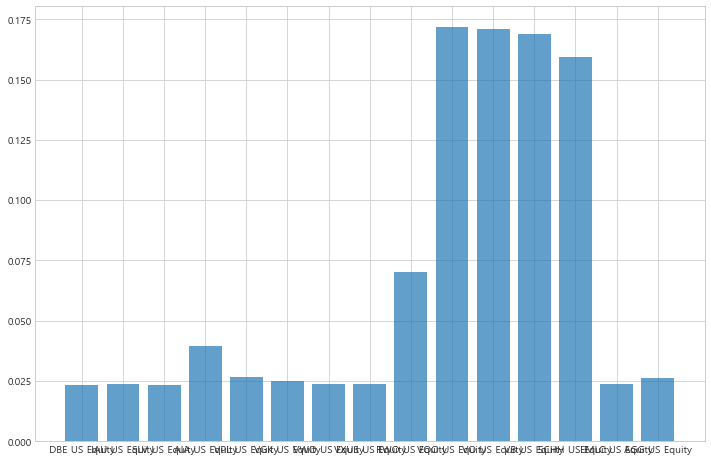

In [22]:
check_w(20)

## 성능 평가

In [23]:
N_TIME = xc_test.shape[1]
N_FUTURE = xf_test.shape[1]
N_STOCKS = xf_test.shape[2]

# 저장된 Markowitz 모델을 가져온다.
SAVE_MODEL = '../model/mpn.h5'
model = load_model(SAVE_MODEL, compile = False)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 15)]          0         
                                                                 
 lstm (LSTM)                 (None, 64)                20480     
                                                                 
 dense (Dense)               (None, 15)                975       
                                                                 
 activation (Activation)     (None, 15)                0         
                                                                 
Total params: 21,455
Trainable params: 21,455
Non-trainable params: 0
_________________________________________________________________


## Backtesting

In [24]:

# 백 테스트를 수행한다.
prt_value = [10000]   # portfolio의 초기 value
crp_value = [10000]   # CRP의 초기 value
w_crp = np.ones(N_STOCKS) / N_STOCKS   # CRP 비율 (균등 비율)

w_history = []
date_history = []
for i in range(0, xc_test.shape[0], N_FUTURE):
    # 이 시점에 각 종목을 w_prt 비율대로 매수한다.
    # 학습할 때 월간 수익률로 변환했으므로, 여기서도 변환해야 한다.
    # x = xc_test[i][np.newaxis,:,:] * 20.0
    x = xc_test[i][np.newaxis,:,:]
    w_prt = model.predict(x)[0]
    w_history.append(w_prt)
    date_history.append(test_date[i])

    # 다음 기의 누적 수익률
    m_rtn = np.sum(xf_test[i]/20, axis = 0)

    # 누적 수익률과 w_prt (W)로 포트폴리오의 수익률을 계산한다.
    prt_value.append(prt_value[-1] * np.exp(np.dot(w_prt, m_rtn)))
    print(f"m_rtn: {m_rtn}")
    print(f"w_prt: {w_prt}")
    crp_value.append(crp_value[-1] * np.exp(np.dot(w_crp, m_rtn)))


m_rtn: [-0.15374818  0.05342144  0.06899288  0.06063476  0.04651967  0.05065759
  0.07080823  0.0622677   0.04360246  0.0886742   0.10795595  0.11176191
  0.05326175  0.02449545  0.01589375]
w_prt: [0.0231594  0.02369546 0.02314217 0.0408718  0.02667627 0.02412732
 0.0233705  0.02341313 0.0778043  0.16965377 0.1688268  0.16733798
 0.15866512 0.0234208  0.02583517]
m_rtn: [ 0.1787942   0.00244499  0.13574527 -0.01064635  0.05417453  0.05675762
  0.03077121  0.04890737  0.02548155  0.06045436  0.0690286   0.10273102
  0.01638959  0.06719752  0.00321314]
w_prt: [0.02348691 0.02383456 0.02343922 0.03941968 0.02676695 0.02482024
 0.02369065 0.02369084 0.07012711 0.17176592 0.17082123 0.16882424
 0.15944976 0.0237675  0.02609515]
m_rtn: [ 0.0726767   0.02947582  0.00801731  0.10208783  0.0337687   0.04032529
  0.07981745  0.04421978 -0.001389    0.00621621 -0.00018681 -0.01665135
 -0.02856642  0.01309349  0.00445411]
w_prt: [0.02391054 0.02424561 0.02391002 0.04041557 0.02693033 0.02560611
 

In [25]:
np_w_history = np.array(w_history)


In [26]:
np.sum(xf_test[0]/20,axis=0)

array([-0.15374818,  0.05342144,  0.06899288,  0.06063476,  0.04651967,
        0.05065759,  0.07080823,  0.0622677 ,  0.04360246,  0.0886742 ,
        0.10795595,  0.11176191,  0.05326175,  0.02449545,  0.01589375],
      dtype=float32)

In [27]:
w_history[0]

array([0.0231594 , 0.02369546, 0.02314217, 0.0408718 , 0.02667627,
       0.02412732, 0.0233705 , 0.02341313, 0.0778043 , 0.16965377,
       0.1688268 , 0.16733798, 0.15866512, 0.0234208 , 0.02583517],
      dtype=float32)

<AxesSubplot:>

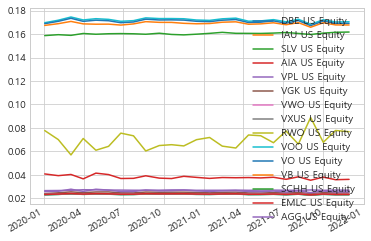

In [28]:
pd.DataFrame(data=np_w_history, index=date_history, columns=tickers).plot()

In [29]:
prt_value

[10000,
 10748.22187423706,
 11382.837361478834,
 11448.377561302146,
 12125.921448882362,
 12534.420319942776,
 12446.657346933209,
 12823.650371128497,
 13442.988708908659,
 13839.848638685613,
 14519.694299472945,
 15179.45995251252,
 15261.9746407462,
 15495.559807698348,
 15874.23327460713,
 16375.172096608847,
 16327.783581396636,
 16397.72052348085,
 16818.08397444822,
 16020.214149331432,
 16968.388161371022,
 16636.5171796678,
 17188.667518316513,
 16015.037910504214,
 15643.21641629529,
 16240.377348944445]

In [30]:
crp_value

[10000,
 10481.359530076772,
 11086.129210784076,
 11376.14531775581,
 12115.242442087274,
 12565.338489290254,
 12539.892060589742,
 12595.67165419617,
 13142.37366772924,
 13528.10770953954,
 14188.187998329926,
 14748.310563598825,
 14628.82522292637,
 14658.533375835672,
 15120.53585547675,
 15550.134678536444,
 15319.302986512897,
 15314.13049906479,
 15503.3667426583,
 14889.628083189045,
 15571.03223919656,
 15039.981956078696,
 15467.519718171248,
 14973.731115136841,
 14849.395825134363,
 15097.709762006512]

In [31]:

# 평가 시점의 날짜를 발췌한다.
# idx = np.arange(0, len(test_date), N_FUTURE)

# Markowitz 성과와 CRP 성과를 데이터 프레임에 기록해 둔다.
# perf_df = pd.DataFrame({'crp':crp_value, 'markowitz':prt_value}, index=test_date[idx])
perf_df = pd.DataFrame({'crp':crp_value, 'markowitz':prt_value})

<AxesSubplot:>

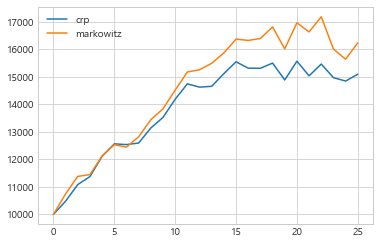

In [32]:
perf_df.plot()